In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [3]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [4]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
        dict_path = 'D:\CIS-PD Study\Data_dict'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'
    
else:
    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
    folder_path = '/Volumes/RTO/CIS-PD Study/'
    dict_path = '../Data_dict' # Mac local path
    scores_path = '../Scores/' # Mac local path
    features_path = '../FeatureMatrix' # Mac local path

# Load data

In [8]:
Data = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_BP.h5'))

#use only hand sensors
Data=Data.drop(['distal_lateral_shank__accel','distal_lateral_shank__gyro','flexor_digitorum__accel','medial_chest_accel','anterior_thigh__accel','anterior_thigh__gyro','sacrum_gyro','sacrum_accel'],axis=1)

print(Data.shape)
Data.head(2)

(48568, 9)


,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,dorsal_hand__accel,dorsal_hand__gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002863198295641151, 0.00356357345517006, 0....","[2.7635771865880097, 1.922690587454126, 4.2009..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002351116887782029, 0.003515693546872984, 0...","[3.3284323758047036, 2.822697515889742, 5.3517..."


In [88]:
# # filename = 'Features_AllLocsBP.pkl'
# # filename = 'Features_AllLocsHP.pkl'
# filename = 'Features_AllLocsHP+LP.pkl'
# Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Data = Data.reset_index(drop=True)
# print(Data.shape)

(48579, 6)


In [9]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,dorsal_hand__accel,dorsal_hand__gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002863198295641151, 0.00356357345517006, 0....","[2.7635771865880097, 1.922690587454126, 4.2009..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002351116887782029, 0.003515693546872984, 0...","[3.3284323758047036, 2.822697515889742, 5.3517..."


#### This section reconciles the following - Load features, merge with metadata from raw datafiles, and resave as pkl file

In [10]:
namesuffix = '_BP.pkl'
# datafile = 'DataRaw_AllLocs'+namesuffix
# featfile = 'Features_AllLocs'+namesuffix
# output = 'MetaFeatures_'+namesuffix

# Data = pickle.load(open(os.path.join(features_path,featfile),'rb'))
# Data = Data.reset_index(drop=True)
# print(Data.shape)
# metadata = pickle.load(open(os.path.join(features_path,datafile),'rb'))
# metadata=metadata.reset_index(drop=True)
# metadata = metadata.iloc[:,:7]
# print(metadata.shape)
# #concatenates metadata
# Data=pd.concat((metadata,Data),axis=1)
# print(Data.shape)
# #save features pkl file
# f = open(os.path.join(features_path,output),'wb')
# pickle.dump(Data,f)
# f.close()

In [11]:
Data.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,dorsal_hand__accel,dorsal_hand__gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002863198295641151, 0.00356357345517006, 0....","[2.7635771865880097, 1.922690587454126, 4.2009..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002351116887782029, 0.003515693546872984, 0...","[3.3284323758047036, 2.822697515889742, 5.3517..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.0024673858459028104, 0.0028924432713214637,...","[2.6885012576952496, 2.8744981875353393, 4.437..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002617071833100416, 0.003720037168994808, 0...","[2.499042347499924, 1.2004465412231244, 4.3006..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.0030835106104448225, 0.004102988642061404, ...","[3.261874206390144, 2.9412816369694337, 4.6892..."


In [12]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

In [6]:
# Data = pd.read_hdf(os.path.join(features_path,'Features_Overlap_HP+LP.h5'))
# print(Data.shape)
# Data.head(2)

(48297, 13)


,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,dorsal_hand__accel,dorsal_hand__gyro,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.014046611028026703, 0.020603451774853176, 0...","[10.273506428273729, 2.706283216342912, 5.0615...","[0.007989930813309471, 0.00961279888662689, 0....","[2.7635771865880097, 1.922690587454126, 4.2009...","[0.002870561203119263, 0.011362069633733492, 0...","[0.8215614656047298, 1.1265178529231297, 0.664..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.012784975789800944, 0.019815286722809262, 0...","[10.66239472590443, 2.6287032265762083, 4.4656...","[0.007692838138012616, 0.009210303186171182, 0...","[3.3284323758047036, 2.822697515889742, 5.3517...","[0.003073760806722303, 0.010809689170103418, 0...","[0.7898793130704667, 3.3456375775178198, 0.722..."


### Filter empty rows on  hand sensors only and unpack features and save

Filter on all locations 

In [13]:
#filter empty rows on all locations
for s in Data.columns.values[7:]:
    print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
    Data = Data[Data[s].apply(type) != float]

dorsal_hand__accel,discarded 6478 rows
dorsal_hand__gyro,discarded 0 rows


Filter on hand only

In [14]:
#filter empty rows (no features available) on hand sensors
print('discarded %d rows'%(len(Data[Data.dorsal_hand__accel.apply(type) == float])))
Data = Data[Data.dorsal_hand__accel.apply(type) != float]
print('discarded %d rows'%(len(Data[Data.dorsal_hand__gyro.apply(type) == float])))
Data = Data[Data.dorsal_hand__gyro.apply(type) != float]

discarded 0 rows
discarded 0 rows


In [15]:
Data.shape

(42090, 9)

In [16]:
Data.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,dorsal_hand__accel,dorsal_hand__gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002863198295641151, 0.00356357345517006, 0....","[2.7635771865880097, 1.922690587454126, 4.2009..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002351116887782029, 0.003515693546872984, 0...","[3.3284323758047036, 2.822697515889742, 5.3517..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.0024673858459028104, 0.0028924432713214637,...","[2.6885012576952496, 2.8744981875353393, 4.437..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.002617071833100416, 0.003720037168994808, 0...","[2.499042347499924, 1.2004465412231244, 4.3006..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.0030835106104448225, 0.004102988642061404, ...","[3.261874206390144, 2.9412816369694337, 4.6892..."


In [20]:
#unpack features
colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
       'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
       'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

# sensor_list = ['anterior_thigh_','dorsal_hand_','sacrum']
sensor_list = ['dorsal_hand_'] # just hand sensors


colnames1=[i+'acc' for i in colnames]
colnames2=[i+'gyr' for i in colnames]
colnames=colnames1+colnames2

In [21]:
len(Data)

42090

In [22]:
Datafinal = pd.DataFrame()

for i in range(len(Data)):
    Datatemp=pd.DataFrame()
    for sensors in sensor_list:
        F1 = Data[sensors + '_accel'].iloc[i]
        F2 = Data[sensors + '_gyro'].iloc[i]
        F = pd.DataFrame(data=np.hstack((F1,F2)).reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames])
        Datatemp=pd.concat((Datatemp,F),axis=1)
    Datafinal = pd.concat((Datafinal,Datatemp),axis=0)

In [23]:
Datafinal.head(3)

,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,rangeXacc_dorsal_hand_,rangeYacc_dorsal_hand_,rangeZacc_dorsal_hand_,meanXacc_dorsal_hand_,meanYacc_dorsal_hand_,meanZacc_dorsal_hand_,varXacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,0.002863,0.003564,0.001774,0.338612,0.329050,0.192626,-0.000462,-0.000083,0.000130,0.050653,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,0.002351,0.003516,0.001453,0.244854,0.329417,0.134421,-0.000492,-0.000866,0.000241,0.041593,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797
2,0.002467,0.002892,0.001290,0.244854,0.260718,0.128082,0.000245,-0.000221,-0.000094,0.043652,...,1497.256257,3.439717,10.691567,0.180830,8.709283,0.326298,0.498028,0.397453,0.464745,0.272388


In [24]:
Datafinal=Datafinal.reset_index(drop=True)
# Datanew=Datanew.reset_index(drop=True)
Data=Data.reset_index(drop=True)

In [25]:
Data = pd.concat((Data.iloc[:,:7],Datafinal),axis=1)

In [26]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.002863,0.003564,0.001774,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.002351,0.003516,0.001453,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [27]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

In [28]:
Datafinal.head(3)

,RMSXacc_dorsal_hand_,RMSYacc_dorsal_hand_,RMSZacc_dorsal_hand_,rangeXacc_dorsal_hand_,rangeYacc_dorsal_hand_,rangeZacc_dorsal_hand_,meanXacc_dorsal_hand_,meanYacc_dorsal_hand_,meanZacc_dorsal_hand_,varXacc_dorsal_hand_,...,PSD_stdgyr_dorsal_hand_,PSD_skewgyr_dorsal_hand_,PSD_kurgyr_dorsal_hand_,jerk_meangyr_dorsal_hand_,jerk_stdgyr_dorsal_hand_,jerk_skewgyr_dorsal_hand_,jerk_kurgyr_dorsal_hand_,Sen_Xgyr_dorsal_hand_,Sen_Ygyr_dorsal_hand_,Sen_Zgyr_dorsal_hand_
0,0.002863,0.003564,0.001774,0.338612,0.329050,0.192626,-0.000462,-0.000083,0.000130,0.050653,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,0.002351,0.003516,0.001453,0.244854,0.329417,0.134421,-0.000492,-0.000866,0.000241,0.041593,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797
2,0.002467,0.002892,0.001290,0.244854,0.260718,0.128082,0.000245,-0.000221,-0.000094,0.043652,...,1497.256257,3.439717,10.691567,0.180830,8.709283,0.326298,0.498028,0.397453,0.464745,0.272388


In [29]:
f = open(os.path.join(features_path,'UnpackedMetaFeat'+namesuffix),'wb')
pickle.dump(Data,f)
f.close()

## Load unpacked features data

In [ ]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Data = Data.reset_index(drop=True)

In [15]:
filename = 'Features_AllLocs_BP.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)
Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)
print(Dataorig.shape)

(42100, 81)
(42100, 81)


In [103]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc_anterior_thigh_,RMSYacc_anterior_thigh_,RMSZacc_anterior_thigh_,...,PSD_stdgyr_sacrum,PSD_skewgyr_sacrum,PSD_kurgyr_sacrum,jerk_meangyr_sacrum,jerk_stdgyr_sacrum,jerk_skewgyr_sacrum,jerk_kurgyr_sacrum,Sen_Xgyr_sacrum,Sen_Ygyr_sacrum,Sen_Zgyr_sacrum
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.014047,0.020603,0.007743,...,16.520433,1.055848,-0.078259,0.106617,9.224923,0.265311,6.435115,0.605546,0.738507,0.925164
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.012785,0.019815,0.007882,...,18.314746,2.340816,5.712469,0.178461,8.523705,0.244776,4.415712,0.623200,0.452800,0.884457


In [17]:
#drop features 
Data=Data.drop(labels=['RMSXacc_dorsal_hand_','RMSYacc_dorsal_hand_','RMSZacc_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc_dorsal_hand_','meanYacc_dorsal_hand_','meanZacc_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc_dorsal_hand_','varYacc_dorsal_hand_','varZacc_dorsal_hand_'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr_dorsal_hand_','RMSYgyr_dorsal_hand_','RMSZgyr_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr_dorsal_hand_','meanYgyr_dorsal_hand_','meanZgyr_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr_dorsal_hand_','varYgyr_dorsal_hand_','varZgyr_dorsal_hand_'],axis=1) #range is strongly correlated with variance

In [104]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [105]:
Data.shape

(40118, 229)

In [106]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

# ALL TASKS


Text(0.5,1,'Tremor')

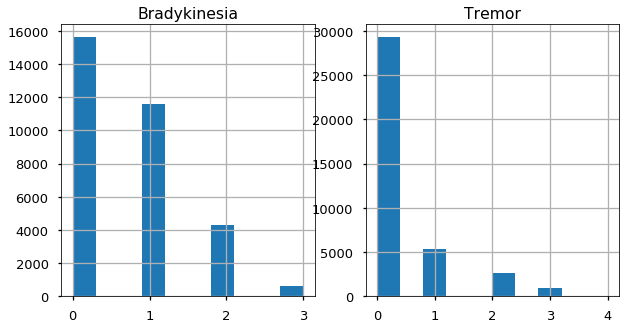

In [107]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

### How many instances of symptoms (>0) we have per subject and task

In [108]:
dd = Data.loc[Data['Task'] == 'Motor #1: Standing']
len(dd['Bradykinesia'] > 0)

3190

(Text(0.5,1,'Tremor - Symptoms > 0 per Task'), Text(0.5,0,'Task'))

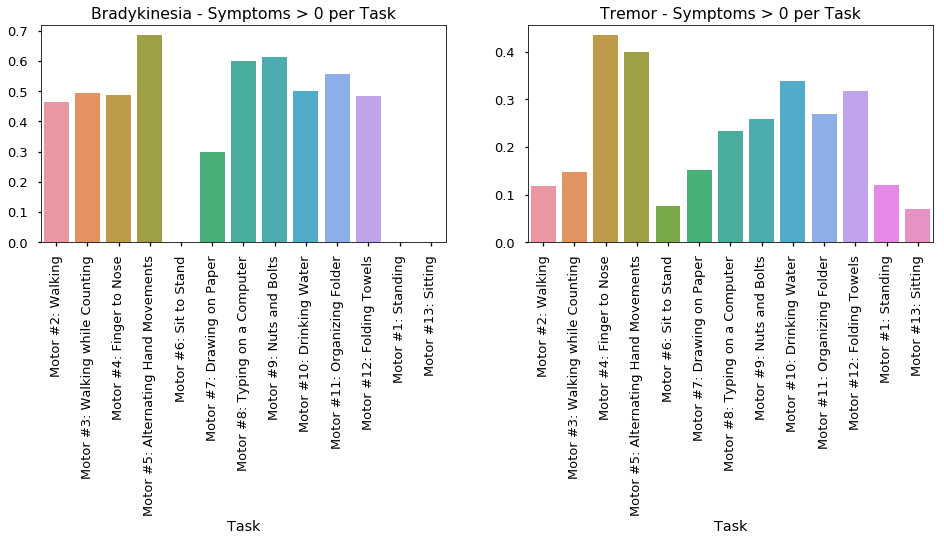

In [110]:
sns.set_context('talk')
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(0, 1)

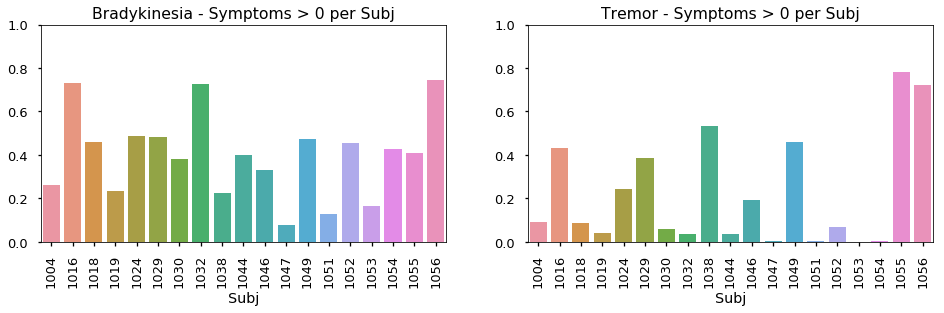

In [111]:
BradP=[]; TremorP=[]; subjs = []
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
    subjs.append(t)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
plt.ylim([0,1])
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.ylim([0,1])

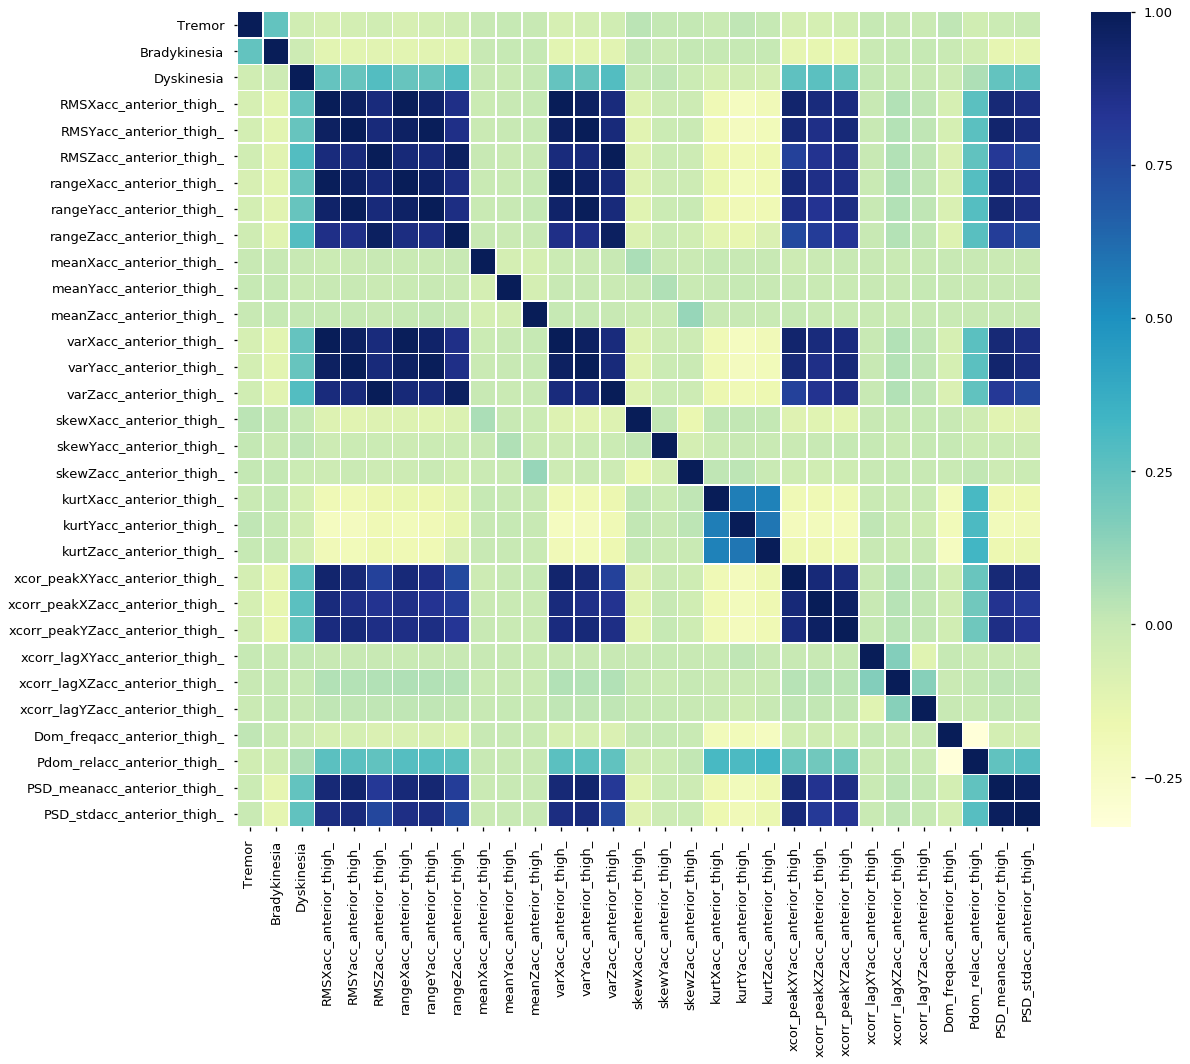

In [112]:
sns.set_context('talk')
f = Data.iloc[:,4:35]
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

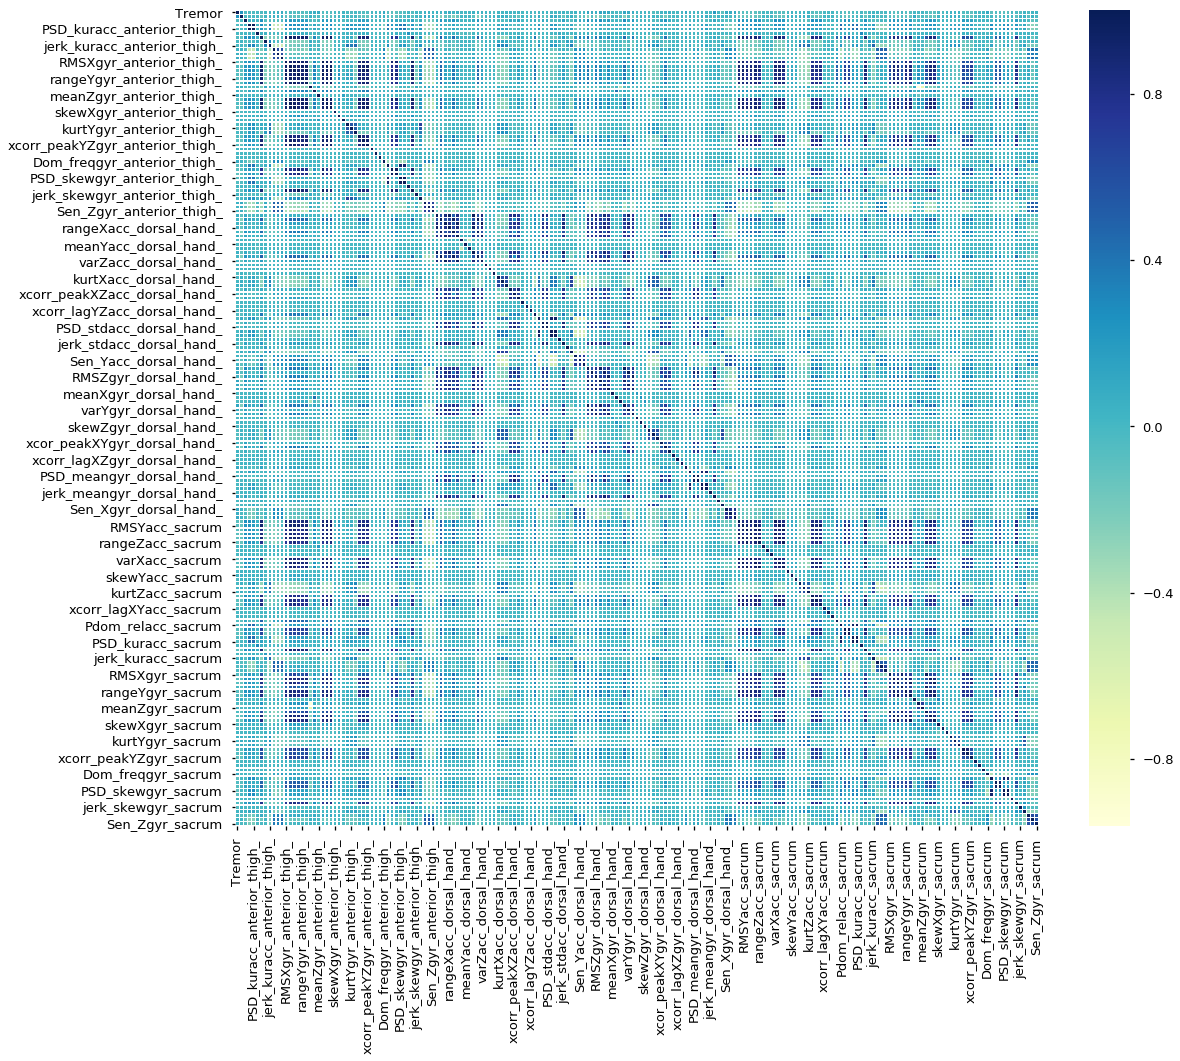

In [113]:
f = Data.iloc[:,4:7]
f = pd.concat((f,Data.iloc[:,35:]),axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

## LOSO CV - ALL TASKS

In [30]:
# #amount of data per subject
# subjdata=[]
# for s in Data.Subject.unique():
# #     print(s,len(Data[Data.Subject==s]))
#     subjdata.append(len(Data[Data.Subject==s]))
    
# sns.barplot(Data.Subject.unique(),subjdata)
# ax=plt.xticks(rotation=90)

In [114]:
Dataorig = Data.copy()

In [115]:
Dataorig['Bradykinesia'].unique()

array([ 1.,  0.,  2., nan,  3.])

In [116]:
Data['Bradykinesia'].unique()

array([ 1.,  0.,  2., nan,  3.])

In [27]:
#conversion to nan
# (Dataorig[Dataorig[symptom].isnull()][symptom]>0)

In [117]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16543/32156 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.452, rec=0.594, Spec=0.640, auroc_train=1.000, auroc=0.684

Subj/Visit 1, prec=0.951, rec=0.679, Spec=0.627, auroc_train=1.000, auroc=0.751

Subj/Visit 2, prec=0.759, rec=0.748, Spec=0.686, auroc_train=1.000, auroc=0.777

Subj/Visit 3, prec=0.443, rec=0.914, Spec=0.541, auroc_train=1.000, auroc=0.775

Subj/Visit 4, prec=0.713, rec=0.646, Spec=0.563, auroc_train=1.000, auroc=0.641

Subj/Visit 5, prec=0.599, rec=0.337, Spec=0.677, auroc_train=1.000, auroc=0.502

Subj/Visit 6, prec=0.637, rec=0.913, Spec=0.514, auroc_train=1.000, auroc=0.764

Subj/Visit 7, prec=0.875, rec=0.637, Spec=0.441, auroc_train=1.000, auroc=0.570

Subj/Visit 8, prec=0.367, rec=0.676, Spec=0.547, auroc_train=1.000, auroc=0.672

Subj/Visit 9, prec=0.658, rec=0.743, Spec=0.624, auroc_train=1.000, auroc=0.760

Subj/Visit 10, prec=0.588, rec=0.517, Spec=0.740, auroc_train=1.000, auroc=0.686

Subj/Visit 11, prec=0.266, rec=0.865, Spec=0.

In [118]:
np.unique(groups)

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056], dtype=int64)

Removing nans

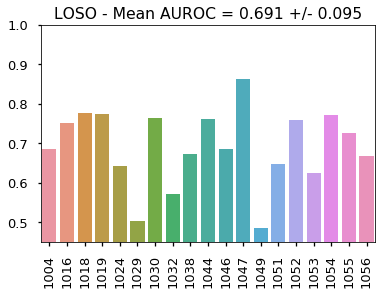

In [120]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('5sensorsLOSO.png',bbox_inches='tight')

### Feature importance

In [ ]:
fi = np.asarray(res_group['Random Forest']['fi'])
meanfi=np.mean(np.asarray(res_group['Random Forest']['fi']),axis=0)
stdfi=np.std(np.asarray(res_group['Random Forest']['fi']),axis=0)

In [ ]:
ax=sns.boxplot(meanfi)

In [ ]:
fnames = Data.iloc[:,7:].columns.values

In [ ]:
plt.figure(figsize=(18,8))
sns.barplot(x=np.arange(len(meanfi)),y=meanfi,ci=stdfi)
ax=plt.xticks(np.arange(len(meanfi)),fnames,rotation=90)

In [ ]:
np.percentile(meanfi,75)

In [ ]:
sum(meanfi>0.02)

In [ ]:
#top features
n = 18
fnames[np.argsort(meanfi)[::-1]][:n]

In [ ]:
sns.barplot(np.arange(n),np.sort(meanfi)[::-1][:n])
ax=plt.xticks(np.arange(n),fnames[np.argsort(meanfi)[::-1]][:n],rotation=90)

In [37]:
t1=time.time()
res_all = pd.DataFrame()

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))
    
    #top features
    topf = fnames[np.argsort(meanfi)[::-1]][:n]
    X = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1).iloc[:,7:].as_matrix()

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16574/32368 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.580, rec=0.606, Spec=0.780, auroc_train=1.000, auroc=0.748

Subj/Visit 1, prec=0.952, rec=0.787, Spec=0.576, auroc_train=1.000, auroc=0.749

Subj/Visit 2, prec=0.733, rec=0.730, Spec=0.649, auroc_train=1.000, auroc=0.751

Subj/Visit 3, prec=0.463, rec=0.928, Spec=0.569, auroc_train=1.000, auroc=0.823

Subj/Visit 4, prec=0.799, rec=0.613, Spec=0.741, auroc_train=1.000, auroc=0.756

Subj/Visit 5, prec=0.615, rec=0.637, Spec=0.430, auroc_train=1.000, auroc=0.538

Subj/Visit 6, prec=0.647, rec=0.770, Spec=0.607, auroc_train=1.000, auroc=0.778

Subj/Visit 7, prec=0.873, rec=0.686, Spec=0.388, auroc_train=1.000, auroc=0.526

Subj/Visit 8, prec=0.335, rec=0.594, Spec=0.542, auroc_train=1.000, auroc=0.592

Subj/Visit 9, prec=0.673, rec=0.832, Spec=0.604, auroc_train=1.000, auroc=0.793

Subj/Visit 10, prec=0.532, rec=0.476, Spec=0.699, auroc_train=1.000, auroc=0.647

Subj/Visit 11, prec=0.286, rec=0.766, Spec=0.

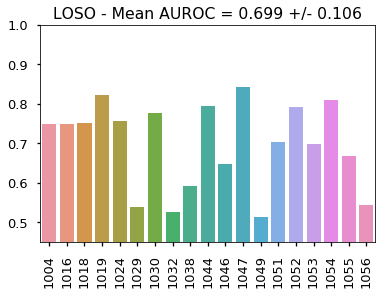

In [38]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Personal Models

In [121]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.721, rec=0.128, Spec=0.613, auroc_train=1.000, auroc=0.444

Subj/Visit 1, prec=0.464, rec=0.371, Spec=0.919, auroc_train=1.000, auroc=0.678

Subj/Visit 2, prec=0.500, rec=0.375, Spec=0.955, auroc_train=1.000, auroc=0.908

Subj/Visit 3, prec=0.720, rec=0.678, Spec=0.839, auroc_train=1.000, auroc=0.774

Subj/Visit 4, prec=0.545, rec=0.692, Spec=0.922, auroc_train=1.000, auroc=0.900

Subj/Visit 5, prec=0.786, rec=0.239, Spec=0.983, auroc_train=1.000, auroc=0.906

Subj/Visit 6, prec=0.685, rec=0.685, Spec=0.839, auroc_train=1.000, auroc=0.861
f1_test=0.488+/-0.167, prec=0.632+/-0.117, rec=0.453+/-0.216, auprc=0.611+/-0.180, auroc=0.782+/-0.159
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.988, rec=0.972, Spec=0.786, auroc_train=1.000, auroc=0.982

Subj/Visit 1, prec=0.967, rec=0.996, Spec=0.733, auroc_train=1.000, auroc=0.981

Subj/Visit 2, prec=0.953, rec=1.000, Spec=0.607, auroc_train=1.000, auroc=0.997

Subj/Visit 3, 

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.871


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.181+/-0.258, prec=0.333+/-0.471, rec=0.125+/-0.179, auprc=0.767+/-0.014, auroc=0.840+/-0.030
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.874, rec=0.848, Spec=0.855, auroc_train=1.000, auroc=0.933

Subj/Visit 1, prec=0.956, rec=0.929, Spec=0.889, auroc_train=1.000, auroc=0.969

Subj/Visit 2, prec=0.915, rec=1.000, Spec=0.143, auroc_train=1.000, auroc=0.906

Subj/Visit 3, prec=1.000, rec=0.962, Spec=1.000, auroc_train=1.000, auroc=0.994

Subj/Visit 4, prec=0.935, rec=0.912, Spec=0.926, auroc_train=1.000, auroc=0.966

Subj/Visit 5, prec=0.910, rec=0.898, Spec=0.893, auroc_train=1.000, auroc=0.956

Subj/Visit 6, prec=0.455, rec=0.319, Spec=0.622, auroc_train=1.000, auroc=0.516
f1_test=0.849+/-0.197, prec=0.864+/-0.171, rec=0.838+/-0.217, auprc=0.907+/-0.177, auroc=0.892+/-0.155
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.0

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.993, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.990
f1_test=0.969+/-0.023, prec=0.955+/-0.034, rec=0.985+/-0.020, auprc=0.994+/-0.006, auroc=0.962+/-0.023


In [51]:
Data.shape

(32368, 63)

In [122]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

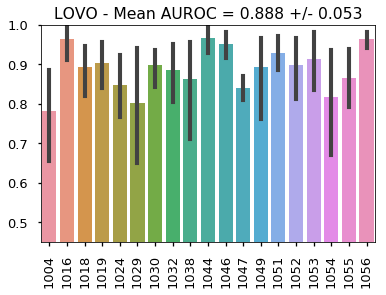

In [124]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1])
plt.savefig('5sensorsLOVO.png',bbox_inches='tight')

Is variability due to variability in symptoms between visits?

# LPGO
train on r subjects and test on remaining p subjects (left out). Compute AUC on left out

In [36]:
Dataorig = Data.copy()
#remove nan symptoms
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]

In [37]:
Data.shape

(32368, 63)

In [21]:
from sklearn.model_selection import LeavePGroupsOut
X = Data.iloc[:,7:].as_matrix()
y = Data[symptom]
groups = Data.Subject
for ng in range(20):
    lpgo = LeavePGroupsOut(n_groups=ng)
    print(ng,lpgo.get_n_splits(X,y,groups))

0 1
1 20
2 190
3 1140
4 4845
5 15504
6 38760
7 77520
8 125970
9 167960
10 184756
11 167960
12 125970
13 77520
14 38760
15 15504
16 4845
17 1140
18 190
19 20


In [29]:
# topf = ['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
#        'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
#        'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
#        'rangeXacc']

In [30]:
topf=['rangeXgyr', 'rangeYacc', 'xcorr_peakXZgyr', 'rangeZacc',
       'Sen_Xgyr', 'xcorr_peakXZacc', 'rangeZgyr', 'jerk_stdgyr',
       'jerk_stdacc', 'kurtZgyr', 'xcorr_peakYZacc', 'xcor_peakXYacc',
       'kurtXgyr', 'rangeXacc', 'PSD_meangyr', 'Sen_Zgyr',
       'xcor_peakXYgyr', 'xcorr_peakYZgyr']

In [11]:
subjs=Data.Subject.unique()
subjs

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056], dtype=int64)

In [153]:
tasks=Data.Task.unique()
tasks

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer',
       'Motor #9: Nuts and Bolts', 'Motor #10: Drinking Water',
       'Motor #11: Organizing Folder', 'Motor #12: Folding Towels'],
      dtype=object)

In [15]:
tr = np.random.choice(subjs,size=3,replace=False)
tr

array([1049, 1047, 1018], dtype=int64)

In [16]:
n = Data.Subject.unique()
test = np.setxor1d(tr,n)
test

array([1004, 1016, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046, 1051,
       1052, 1053, 1054, 1055, 1056], dtype=int64)

In [17]:
te = np.random.choice(test,size=1,replace=False)
te

array([1051], dtype=int64)

In [12]:
Data=Data[~Data['Bradykinesia'].isnull()]
Data.Bradykinesia.unique()

array([1., 0., 2., 3.])

## Global Models

In [155]:
subjs=Data.Subject.unique()
tasks=Data.Task.unique()

#sample p subjects at random for train and test on remaining
symptom = 'Bradykinesia'
ntrain = [4,8,16]
# ntrain = [2,4,8,12]
clf = RandomForestClassifier(n_estimators=50,random_state=2)

#remove nan rows for current symptom
Data=Data[~Data[symptom].isnull()]

results={}
for ng in ntrain:
    auc_all=[]; subj=[]; tasks_all=[];
    t1=time.time()
    for iteration in range(500):
        trainsubj = np.random.choice(subjs,size=ng,replace=False) #sample subjects at random
        
        # select random test subject out of remaining subjs not trained on
        testsubj = np.random.choice(np.setxor1d(subjs,trainsubj),size=1,replace=False)
        
        dtrain = Data[Data.Subject.isin(trainsubj)]
        dtest = Data[Data.Subject.isin(testsubj)]
        Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
#         Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)
        #use top features
        Xte = dtest.iloc[:,7:].as_matrix()
#         Xte = dtest[topf].as_matrix()
        yte = (dtest[symptom]>0).values.astype(int)
        ytask = dtest[dtest[symptom]>0].Task
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        
        auc_all.append(auroc)
        subj.append(testsubj)
        tasks_all.append(ytask)
        
        if iteration%50==0:
            print('Subj=%s,Test=%s,Iter=%d, AUROC=%.3f'%(trainsubj,testsubj,iteration,auroc))

    results.update({ng:[auc_all,subj,tasks_all]}) #save auc for all runs for each group
    print('elapsed %.3f min'%((time.time()-t1)/60))


Subj=[1054 1032 1016 1004],Test=[1047],Iter=0, AUROC=0.819
Subj=[1024 1047 1018 1053],Test=[1016],Iter=50, AUROC=0.817
Subj=[1024 1029 1049 1016],Test=[1053],Iter=100, AUROC=0.701
Subj=[1053 1038 1032 1019],Test=[1046],Iter=150, AUROC=0.772
Subj=[1056 1049 1030 1032],Test=[1018],Iter=200, AUROC=0.659
Subj=[1024 1018 1020 1046],Test=[1004],Iter=250, AUROC=0.688
Subj=[1038 1053 1018 1055],Test=[1044],Iter=300, AUROC=0.751
Subj=[1053 1055 1029 1024],Test=[1016],Iter=350, AUROC=0.782
Subj=[1020 1047 1052 1019],Test=[1030],Iter=400, AUROC=0.699
Subj=[1029 1020 1055 1004],Test=[1052],Iter=450, AUROC=0.756
elapsed 17.182 min
Subj=[1054 1004 1030 1051 1047 1018 1055 1038],Test=[1052],Iter=0, AUROC=0.787
Subj=[1044 1046 1020 1004 1053 1051 1016 1018],Test=[1030],Iter=50, AUROC=0.826
Subj=[1024 1053 1055 1029 1038 1049 1051 1030],Test=[1047],Iter=100, AUROC=0.781
Subj=[1030 1004 1051 1018 1029 1056 1038 1053],Test=[1032],Iter=150, AUROC=0.511
Subj=[1056 1049 1018 1032 1053 1004 1029 1038],Test=[

In [156]:
np.save('subjsims_randomTest_taskList.npy',results)

In [165]:
np.save('subjsims_optfeat.npy',results)

In [90]:
#load sim results
r = np.load('subjsims_randomTest_subjList.npy')
r2=r.item()

In [157]:
for sub in Data.Task.unique():
    plt.figure(figsize=(8,6));
    for n in r2.keys():
        all_results = np.expand_dims(r2[n][0],1);
#         subject_list = np.array(r2[n][1]);
        task_list = r2[n][2];
        
        inds = [i for i, s in enumerate(task_list) if s == sub]
        
        d = all_results[inds]
        
        ax=sns.distplot(d);
        ax.legend(r2.keys());
    plt.title('Task %s results'%sub);
    plt.savefig('Task%s.png'%sub, bbox_inches='tight');
        

IndexError: list index out of range

ValueError: color kwarg must have one color per dataset

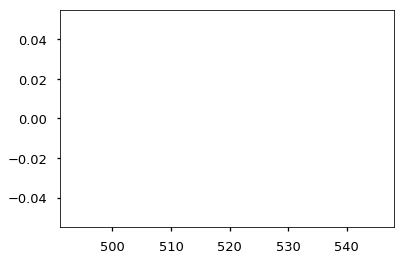

In [22]:
for i in results.keys():
    ax=sns.distplot(results[i])
    ax.legend(results.keys())
plt.title('random test features set')
plt.savefig('testRandomResults.png',bbox_inches='tight')

## Personal Models - Train on One Session Test on Rest

Training on 1 session, testing on remainder...
Training Random Forest

Subj/Visit 0, prec=0.578, rec=0.865, Spec=0.434, auroc_train=1.000, auroc=0.737

Subj/Visit 1, prec=0.776, rec=0.581, Spec=0.814, auroc_train=1.000, auroc=0.785

Subj/Visit 2, prec=0.801, rec=0.524, Spec=0.854, auroc_train=1.000, auroc=0.785

Subj/Visit 3, prec=0.636, rec=0.821, Spec=0.542, auroc_train=1.000, auroc=0.761

Subj/Visit 4, prec=0.752, rec=0.685, Spec=0.759, auroc_train=1.000, auroc=0.795

Subj/Visit 5, prec=0.739, rec=0.674, Spec=0.741, auroc_train=1.000, auroc=0.782
f1_test=0.688+/-0.030, prec=0.714+/-0.080, rec=0.692+/-0.121, auprc=0.764+/-0.034, auroc=0.774+/-0.020
Testing on day 2


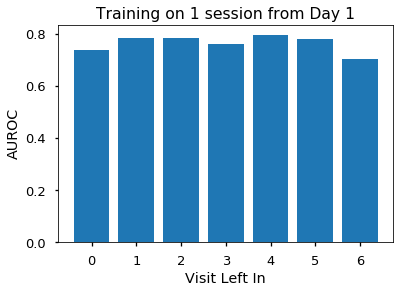

In [88]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
print('Training on 1 session, testing on remainder...')
ds = Data.loc[Data.Visit != '4 Weeks']
ds2 = Data.loc[Data.Visit == '4 Weeks'] #(Day 2)

#train/test on Day 1
indp = (ds[symptom]>0).values
y = indp.astype(int) #target 
X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data

models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = le.fit_transform(ds.Visit)
# if len(np.unique(groups))<2:
#     continue

#train/test on day 1 (LOin)
res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
#     res.index = res.index+s
res_all=pd.concat((res_all,res))
res_visit_all.append(res_group)
# day1_1 = res_all.auroc #mean auc per subject across 
day1_1 = res_group['Random Forest']['auroc']

#test on day 2    
if ds2.empty is False:
    print('Testing on day 2')
    clf = models[0][0]
    X2 = ds2.iloc[:,7:].as_matrix()
    yte = (ds2[symptom]>0).values.astype(int) 
    yscore = clf.predict_proba(X2)
    yscore = yscore[:,1]
    if len(np.unique(yte))>1:
        auroc = roc_auc_score(yte,yscore)
    else:
        print('only 1 class in test data - cannot compute roc curve')
        auroc = np.nan
    auroc2_1.append(auroc) #auc from each subject when tested on day 2

plt.bar(range(7),list(np.squeeze([day1_1 + auroc2_1])));
plt.title('Training on 1 session from Day 1');
plt.xlabel('Visit Left In');
plt.ylabel('AUROC');
plt.savefig('LOVI-Global.png',bbox_inches='tight')

    


## Personal Models - Train on 5 visits, test on remaining

Training on 5 visits...
Training Random Forest

Subj/Visit 0, prec=0.852, rec=0.711, Spec=0.736, auroc_train=1.000, auroc=0.796

Subj/Visit 1, prec=0.686, rec=0.790, Spec=0.726, auroc_train=1.000, auroc=0.840

Subj/Visit 2, prec=0.642, rec=0.785, Spec=0.691, auroc_train=1.000, auroc=0.827

Subj/Visit 3, prec=0.791, rec=0.710, Spec=0.733, auroc_train=1.000, auroc=0.798

Subj/Visit 4, prec=0.712, rec=0.740, Spec=0.730, auroc_train=1.000, auroc=0.815

Subj/Visit 5, prec=0.730, rec=0.789, Spec=0.758, auroc_train=1.000, auroc=0.856
f1_test=0.741+/-0.022, prec=0.735+/-0.069, rec=0.754+/-0.035, auprc=0.812+/-0.036, auroc=0.822+/-0.022
Testing on day 2


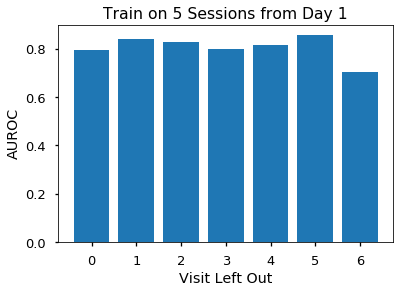

In [89]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
print('Training on 5 visits...')
ds = Data.loc[Data.Visit != '4 Weeks']
ds2 = Data.loc[Data.Visit == '4 Weeks'] #(Day 2)

#train/test on Day 1
indp = (ds[symptom]>0).values
y = indp.astype(int) #target 
X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data

models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = le.fit_transform(ds.Visit)
# if len(np.unique(groups))<2:
#     continue

#train/test on day 1 (LOin)
res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
# res.index = res.index+s
res_all=pd.concat((res_all,res))
res_visit_all.append(res_group)
day1_5 = res_group['Random Forest']['auroc'] #mean auc per subject across 

#test on day 2    
if ds2.empty is False:
    print('Testing on day 2')
    clf = models[0][0]
    X2 = ds2.iloc[:,7:].as_matrix()
    yte = (ds2[symptom]>0).values.astype(int) 
    yscore = clf.predict_proba(X2)
    yscore = yscore[:,1]
    if len(np.unique(yte))>1:
        auroc = roc_auc_score(yte,yscore)
    else:
        print('only 1 class in test data - cannot compute roc curve')
        auroc = np.nan
    auroc2_5.append(auroc) #auc from each subject when tested on day 2

plt.bar(range(7),list(np.squeeze([day1_5 + auroc2_1])));
plt.xlabel('Visit Left Out');
plt.ylabel('AUROC');
plt.title('Train on 5 Sessions from Day 1')
plt.savefig('LOVO-Global.png',bbox_inches='tight')

In [ ]:
def LPGOCV(X,y,groups,models,ng):

    subj = LeavePGroupsOut(n_groups=ng) 
    results = pd.DataFrame(data=None,columns=['model','f1','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres

# Subgroup of tasks (4)

In [6]:
filename = 'Features_AllLocsHP+LP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)

In [7]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

Dataorig = Data.copy()
#remove nan symptoms
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]

Features_AllLocsHP+LP_Hand_Hand.pkl


In [8]:
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]


 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Rows w Bradykinesia 1877/3187 = 0.59
Training Random Forest

Subj/Visit 0, prec=0.605, rec=0.310, Spec=0.794, auroc_train=1.000, auroc=0.625

Subj/Visit 1, prec=0.633, rec=0.922, Spec=0.035, auroc_train=1.000, auroc=0.366

Subj/Visit 2, prec=0.685, rec=0.980, Spec=0.274, auroc_train=1.000, auroc=0.859

Subj/Visit 3, prec=0.657, rec=0.887, Spec=0.589, auroc_train=1.000, auroc=0.860

Subj/Visit 4, prec=0.967, rec=0.773, Spec=0.667, auroc_train=1.000, auroc=0.879

Subj/Visit 5, prec=0.415, rec=0.844, Spec=0.283, auroc_train=1.000, auroc=0.626

Subj/Visit 6, prec=0.780, rec=0.909, Spec=0.456, auroc_train=1.000, auroc=0.787
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.984, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.587, rec=0.871, Spec=0.296, auroc_train=1.000, auroc=0.580

Subj/Visit 9, prec=0.433, rec=1.000, Spec=0.220, auroc_train=1.000, auroc=0.739

Subj/Visit 10, prec=0.719, rec=0.885, Spec=0.671, auroc_train=1.000, auroc=0.868

Subj/Visit 11, prec=0.429, rec=0.913, Spec=0.743, auroc_train=1.000, auroc=0.892
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.989, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.652, rec=0.273, Spec=0.921, auroc_train=1.000, auroc=0.733

Subj/Visit 14, prec=0.779, rec=0.882, Spec=0.802, auroc_train=1.000, auroc=0.841

Subj/Visit 15, prec=0.208, rec=0.444, Spec=0.390, auroc_train=1.000, auroc=0.404

Subj/Visit 16, prec=0.831, rec=0.843, Spec=0.786, auroc_train=1.000, auroc=0.865

Subj/Visit 17, prec=0.882, rec=0.529, Spec=0.872, auroc_train=1.000, auroc=0.726
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.714, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.709+/-0.191, prec=0.698+/-0.218, rec=0.787+/-0.222, auprc=0.744+/-0.211, auroc=0.728+/-0.161


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



 ['Motor #2: Walking' 'Motor #3: Walking while Counting']
Rows w Bradykinesia 3240/6685 = 0.48
Training Random Forest

Subj/Visit 0, prec=0.760, rec=0.709, Spec=0.905, auroc_train=1.000, auroc=0.840

Subj/Visit 1, prec=0.965, rec=0.899, Spec=0.000, auroc_train=1.000, auroc=0.488

Subj/Visit 2, prec=0.941, rec=1.000, Spec=0.938, auroc_train=1.000, auroc=0.988

Subj/Visit 3, prec=1.000, rec=0.994, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.394, rec=1.000, Spec=0.648, auroc_train=1.000, auroc=0.888

Subj/Visit 5, prec=0.510, rec=0.083, Spec=0.528, auroc_train=1.000, auroc=0.378

Subj/Visit 6, prec=0.920, rec=0.988, Spec=0.927, auroc_train=1.000, auroc=0.957

Subj/Visit 7, prec=0.580, rec=0.851, Spec=0.171, auroc_train=1.000, auroc=0.609

Subj/Visit 8, prec=0.764, rec=0.546, Spec=0.832, auroc_train=1.000, auroc=0.774

Subj/Visit 9, prec=0.864, rec=0.984, Spec=0.844, auroc_train=1.000, auroc=0.973
only 1 class in test data - cannot compute roc curve

Subj/Visit 10, pr

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 11, prec=0.676, rec=0.962, Spec=0.904, auroc_train=1.000, auroc=0.962

Subj/Visit 12, prec=0.333, rec=0.282, Spec=0.563, auroc_train=1.000, auroc=0.379

Subj/Visit 13, prec=0.625, rec=0.581, Spec=0.898, auroc_train=1.000, auroc=0.830

Subj/Visit 14, prec=0.720, rec=0.663, Spec=0.878, auroc_train=1.000, auroc=0.826

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.681, auroc_train=1.000, auroc=0.421

Subj/Visit 16, prec=0.934, rec=0.715, Spec=0.951, auroc_train=1.000, auroc=0.895

Subj/Visit 17, prec=1.000, rec=0.062, Spec=1.000, auroc_train=1.000, auroc=0.787

Subj/Visit 18, prec=0.824, rec=0.645, Spec=0.703, auroc_train=1.000, auroc=0.700
f1_test=0.650+/-0.293, prec=0.727+/-0.263, rec=0.663+/-0.327, auprc=0.736+/-0.244, auroc=0.761+/-0.210

 ['Motor #10: Drinking Water' 'Motor #11: Organizing Folder'
 'Motor #12: Folding Towels']
Rows w Bradykinesia 6214/12167 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.564, rec=0.617, Spec=0.829, auroc_train=1.000, auroc=0.777
only 1 

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 2, prec=0.761, rec=0.596, Spec=0.598, auroc_train=1.000, auroc=0.623

Subj/Visit 3, prec=0.253, rec=0.829, Spec=0.509, auroc_train=1.000, auroc=0.723

Subj/Visit 4, prec=0.739, rec=0.415, Spec=0.758, auroc_train=1.000, auroc=0.642

Subj/Visit 5, prec=0.436, rec=0.796, Spec=0.344, auroc_train=1.000, auroc=0.649

Subj/Visit 6, prec=0.367, rec=0.599, Spec=0.438, auroc_train=1.000, auroc=0.519
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.589, Spec=nan, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.168, rec=0.479, Spec=0.554, auroc_train=1.000, auroc=0.542

Subj/Visit 9, prec=0.585, rec=0.740, Spec=0.558, auroc_train=1.000, auroc=0.700

Subj/Visit 10, prec=0.036, rec=0.182, Spec=0.874, auroc_train=1.000, auroc=0.678

Subj/Visit 11, prec=0.090, rec=0.786, Spec=0.703, auroc_train=1.000, auroc=0.846

Subj/Visit 12, prec=0.484, rec=0.460, Spec=0.510, auroc_train=1.000, auroc=0.483

Subj/Visit 13, prec=0.024, rec=0.364, Spec=0.630, auroc_train=1.000, auroc=0.432

Subj/Visit 14, prec=0.864, rec=0.577, Spec=0.819, auroc_train=1.000, auroc=0.790

Subj/Visit 15, prec=0.080, rec=0.846, Spec=0.652, auroc_train=1.000, auroc=0.835

Subj/Visit 16, prec=0.672, rec=0.653, Spec=0.742, auroc_train=1.000, auroc=0.746

Subj/Visit 17, prec=0.625, rec=0.617, Spec=0.250, auroc_train=1.000, auroc=0.417
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.457, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.478+/-0.229, prec=0.513+/-0.328, rec=0.59

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



 ['Motor #7: Drawing on Paper' 'Motor #8: Typing on a Computer'
 'Motor #9: Nuts and Bolts']
Rows w Bradykinesia 5243/10329 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.469, rec=0.587, Spec=0.704, auroc_train=1.000, auroc=0.694

Subj/Visit 1, prec=1.000, rec=0.863, Spec=1.000, auroc_train=1.000, auroc=0.998

Subj/Visit 2, prec=0.686, rec=0.836, Spec=0.664, auroc_train=1.000, auroc=0.844

Subj/Visit 3, prec=0.427, rec=0.970, Spec=0.589, auroc_train=1.000, auroc=0.905

Subj/Visit 4, prec=0.892, rec=0.668, Spec=0.728, auroc_train=1.000, auroc=0.794

Subj/Visit 5, prec=0.920, rec=0.892, Spec=0.743, auroc_train=1.000, auroc=0.887

Subj/Visit 6, prec=0.736, rec=0.814, Spec=0.618, auroc_train=1.000, auroc=0.830

Subj/Visit 7, prec=0.840, rec=0.608, Spec=0.687, auroc_train=1.000, auroc=0.720

Subj/Visit 8, prec=0.248, rec=0.630, Spec=0.477, auroc_train=1.000, auroc=0.587

Subj/Visit 9, prec=0.745, rec=0.796, Spec=0.642, auroc_train=1.000, auroc=0.814

Subj/Visit 10, prec=0.380, rec=0.5

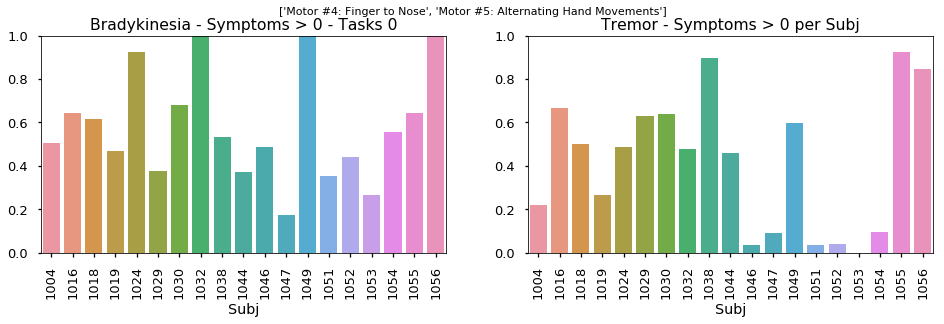

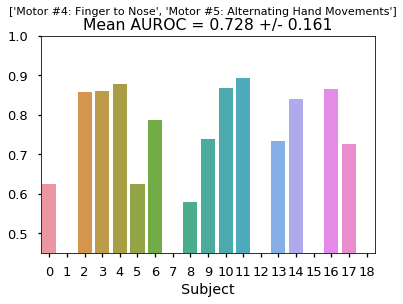

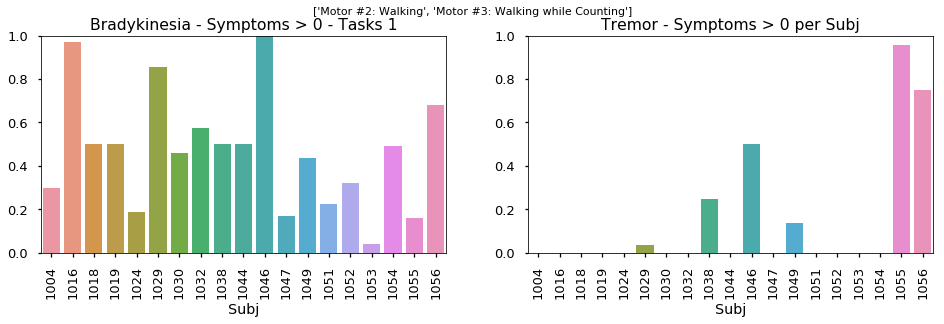

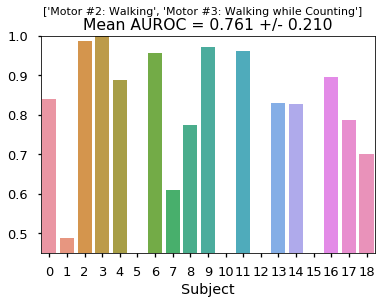

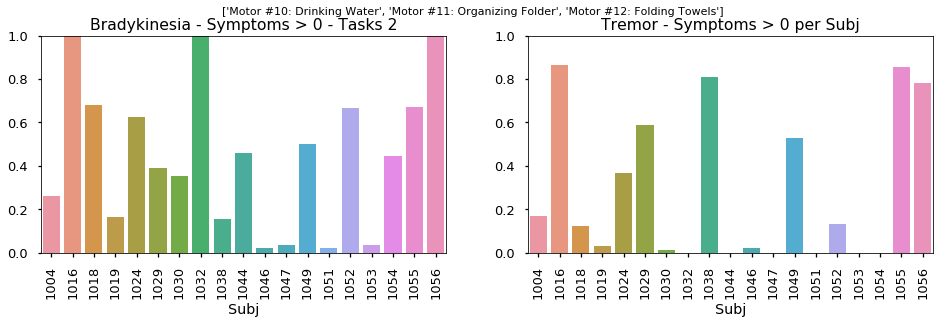

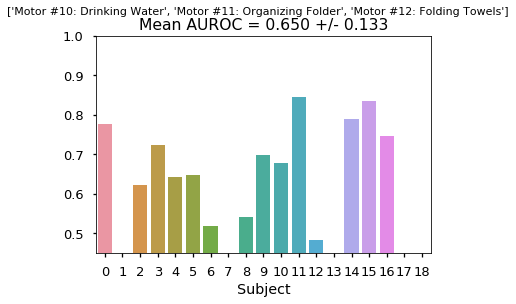

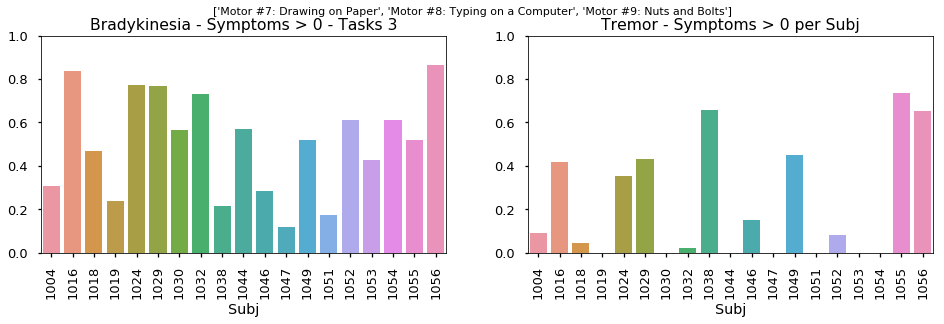

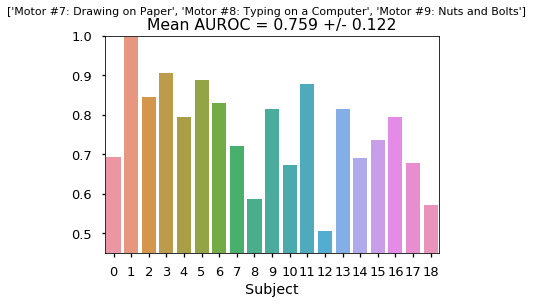

In [46]:
for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    plt.suptitle('%s'%T,fontsize=11)
    plt.savefig('Symptoms_{0}.png'.format(i),bbox_inches='tight')
    
    #train clf on subtasks
    res_all = pd.DataFrame()
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Bradykinesia']:
        
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
        plt.suptitle('%s'%T,fontsize=11)
        plt.savefig('Results_{0}.png'.format(i),bbox_inches='tight')




### Personal models

In [16]:
res_visit_all[i]['Random Forest']['auroc']

[nan, nan, nan, nan, nan, nan]

In [14]:
for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
        
    #train clf on subtasks
    res_all = pd.DataFrame()
    X = Data.iloc[:,7:].as_matrix()
    fnames = Data.iloc[:,7:].columns
    
    res_all = pd.DataFrame(data=None,index=None)
    #train on all sessions, predict on left out session for each patient
    res_visit_all = [] #data from each subject 
    for s in Data.Subject.unique():
        print('Subject %s'%s)
        ds = Data.loc[Data.Subject==s]
        indp = (ds[symptom]>0).values
        y = indp.astype(int) #target 
        X = ds.iloc[:,7:].as_matrix()
#             X_std = StandardScaler().fit_transform(X) #standardize input data
        models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
        model_name = ['Random Forest']#,'XGB']
        models = list(zip(models,model_name))
        groups = le.fit_transform(ds.Visit)
        if len(np.unique(groups))<2:
            continue
        res,res_group = LOSOCV(ds,X,y,groups,models)
        res.index = res.index+s
        res_all=pd.concat((res_all,res))
        res_visit_all.append(res_group)

    #plot results across subjects
    #compute mean and std auc
    auc_mean = []; auc_std = []
    aucdf = pd.DataFrame()
    for i in range(len(res_visit_all)):
        if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
            res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
        aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
        auc_i = res_visit_all[i]['Random Forest']['auroc']
        auc_mean.append(np.nanmean(auc_i)) #mean across visits
        auc_std.append(np.nanstd(auc_i))
    plt.figure()
    sns.barplot(data=aucdf)
    ax=plt.xticks(rotation=90)
    plt.title('LOVO - Tasks %d'%(i))



 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Subject 1004
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.660, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.077, rec=0.091, Spec=0.657, auroc_train=1.000, auroc=0.655

Subj/Visit 2, prec=0.538, rec=0.583, Spec=0.824, auroc_train=1.000, auroc=0.808

Subj/Visit 3, prec=0.533, rec=0.640, Spec=0.440, auroc_train=1.000, auroc=0.594

Subj/Visit 4, prec=0.520, rec=1.000, Spec=0.676, auroc_train=1.000, auroc=0.728

Subj/Visit 5, prec=0.950, rec=0.792, Spec=0.958, auroc_train=1.000, auroc=0.965
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.565, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.613+/-0.238, prec=0.660+/-0.318, rec=0.619+/-0.256, auprc=0.668+/-0.297
Subject 1016
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.792, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.375, rec=1.000, Spec=0.444, auroc_train=1.000, auroc=0.944

Subj/Visit 2, prec=0.333, rec=1.000, Spec=0.412, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=0.545, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.750, rec=0.900, Spec=0.750, auroc_train=1.000, auroc=0.908
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.542, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.730+/-0.156, prec=0.780+/-0.282, rec=0.814+/-0.183, auprc=0.961+/-0.065
Subject 1018
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.458, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.889, rec=1.000, Spec=0.875, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.455, rec=1.000, Spec=0.647, auroc_train=1.000, auroc=0.906

Subj/Visit 3, prec=0.650, rec=1.000, Spec=0.462, auroc_train=1.000, auroc=0.988

Subj/Visit 4, prec=0.923, rec=1.000, Spec=0.917, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.833, rec=0.833, Spec=0.833, auroc_train=1.000, auroc=0.931
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.778+/-0.131, prec=0.821+/-0.186, rec=0.827+/-0.228, auprc=0.902+/-0.205
Subject 1019
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.765, rec=0.684, Spec=0.429, auroc_train=1.000, auroc=0.695

Subj/Visit 1, prec=0.857, rec=1.000, Spec=0.944, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.529, Spec=1.000, auroc_train=1.000, auroc=0.706

Subj/Visit 4, prec=0.917, rec=0.917, Spec=0.917, auroc_train=1.000, auroc=0.965

Subj/Visit 5, prec=0.857, rec=1.000, Spec=0.938, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.923, rec=0.857, Spec=0.929, auroc_train=1.000, auroc=0.982
f1_test=0.867+/-0.106, prec=0.903+/-0.078, rec=0.855+/-0.170, auprc=0.967+/-0.037
Subject 1020
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan
Subject 1024
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=1.000, rec=0.818, Spec=nan, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.983+/-0.037, prec=1.000+/-0.000, rec=0.970+/-0.068, auprc=1.000+/-0.000
Subject 1029
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.500, rec=1.000, Spec=0.700, auroc_train=1.000, auroc=0.800

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.917, Spec=1.000, auroc_train=1.000, auroc=1.000
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.500, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=1.000, rec=0.800, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.714, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.751+/-0.322, prec=0.786+/-0.364, rec=0.752+/-0.322, auprc=0.897+/-0.231
Subject 1030
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.950, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.580

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.939+/-0.088, prec=0.905+/-0.151, rec=0.993+/-0.017, auprc=0.89

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.538, Spec=1.000, auroc_train=1.000, auroc=0.994

Subj/Visit 2, prec=1.000, rec=0.846, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.667, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.840

Subj/Visit 4, prec=0.467, rec=1.000, Spec=0.579, auroc_train=1.000, auroc=0.887

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.522, rec=1.000, Spec=0.083, auroc_train=1.000, auroc=0.962
f1_test=0.772+/-0.129, prec=0.808+/-0.229, rec=0.841+/-0.210, auprc=0.935+/-0.092
Subject 1044
Training Random Forest

Subj/Visit 0, prec=0.692, rec=0.750, Spec=0.667, auroc_train=1.000, auroc=0.812
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.750, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=1.000, rec=0.857, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.786, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.833, rec=0.833, Spec=0.938, auroc_train=1.000, auroc=0.974

Subj/Visit 6, prec=1.000, rec=0.350, Spec=1.000, auroc_train=1.000, auroc=0.592
f1_test=0.683+/-0.308, prec=0.789+/-0.341, rec=0.630+/-0.304, auprc=0.932+/-0.080
Subject 1046
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.944, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=0.500, rec=1.000, Spec=0.706, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.833, rec=1.000, Spec=0.941, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.312, Spec=1.000, auroc_train=1.000, auroc=0.922

Subj/Visit 4, prec=0.438, rec=1.000, Spec=0.526, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.714, rec=1.000, Spec=0.882, auroc_train=1.000, aur

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.625, rec=0.833, Spec=0.500, auroc_train=1.000, auroc=0.837
only 1 class in test data - cannot compute roc curve


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.727, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.222+/-0.353, prec=0.232+/-0.380, rec=0.223+/-0.354, auprc=0.932+/-0.068
Subject 1049
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.955, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.833, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invali

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.958, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.700, auroc_train=1.000, auroc=nan
f1_test=0.235+/-0.352, prec=0.333+/-0.471, rec=0.194+/-0.311, auprc=1.000+/-0.000
Subject 1054
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.667, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=1.000, rec=0.900, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.643, rec=0.600, Spec=0.000, auroc_train=1.000, auroc=0.180

Subj/Visit 4, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.500, rec=1.000, Spec=0.667, auroc_train=1.000, auroc=0.920
f1_test=0.784+/-0.146, prec=0.857+/-0.206, rec=0.778+/-0.198, auprc=0.898+/-0.158
Subject 1055
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1.000, rec=0.455, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 1, prec=0.250, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=0.683

Subj/Visit 3, prec=0.750, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.722
only 1 class in test data - cannot compute roc curve


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 4, prec=1.000, rec=0.545, Spec=nan, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.429, rec=1.000, Spec=0.500, auroc_train=1.000, auroc=0.938
f1_test=0.642+/-0.136, prec=0.738+/-0.300, rec=0.750+/-0.251, auprc=0.936+/-0.074
Subject 1056
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: Mean of empty slice


ValueError: Length of values does not match length of index

In [12]:
# symptom = 'Bradykinesia'
# le = LabelEncoder()
# res_all = pd.DataFrame(data=None,index=None)
# #train on all sessions, predict on left out session for each patient
# res_visit_all = [] #data from each subject 
# for s in Data.Subject.unique():
#     print('Subject %s'%s)
#     ds = Data.loc[Data.Subject==s]
#     indp = (ds[symptom]>0).values
#     y = indp.astype(int) #target 
#     X = ds.iloc[:,7:]
#     X_std = StandardScaler().fit_transform(X) #standardize input data
#     models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
#     model_name = ['Random Forest']#,'XGB']
#     models = list(zip(models,model_name))
#     groups = le.fit_transform(ds.Visit)
#     if len(np.unique(groups))<2:
#         continue
#     res,res_group = LOSOCV(ds,X_std,y,groups,models)
#     res.index = res.index+s
#     res_all=pd.concat((res_all,res))
#     res_visit_all.append(res_group)


In [1093]:
#compute mean and std auc
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


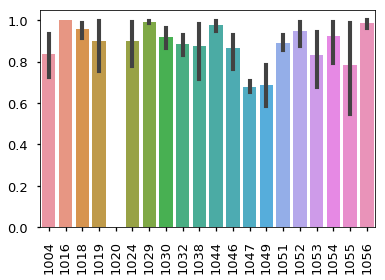

In [1097]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO')

### Structured Tasks

In [945]:
DataStr=pd.DataFrame()
tasks= ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
for t in tasks: 
    DataStr=pd.concat((DataStr,Data[Data.Task==t]))

In [946]:
Data = DataStr.copy()

In [947]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [948]:
Data=Data[Data.Subject!=1020] #subj does not have scores for 0-5

In [949]:
Data.Task.unique()

array(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'], dtype=object)

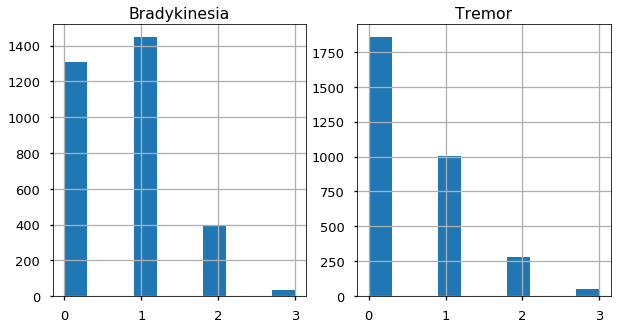

In [950]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

### How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x2b53a8390>, <matplotlib.text.Text at 0x14b9a9470>)

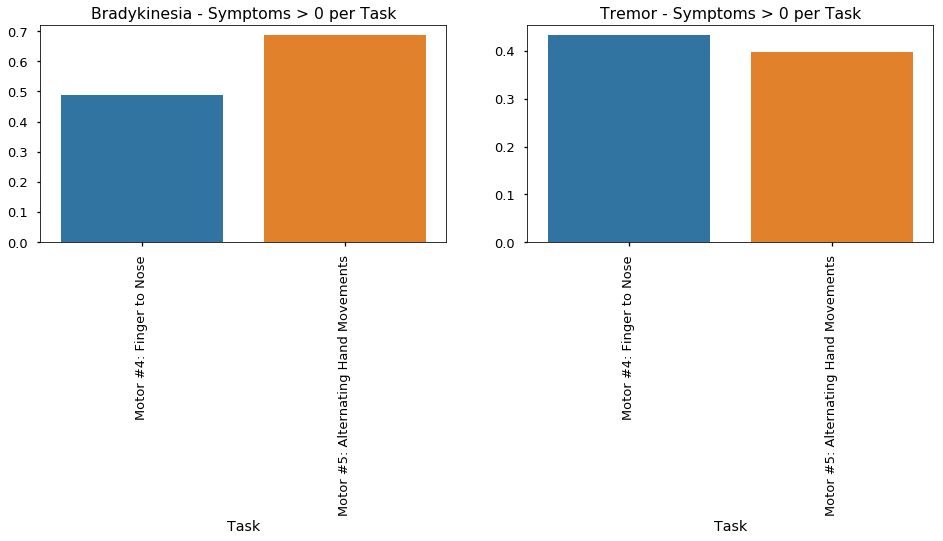

In [951]:
sns.set_context('talk')
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.xticks(np.arange(len(BradP)),Data.Task.unique(),rotation=90)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(0, 1)

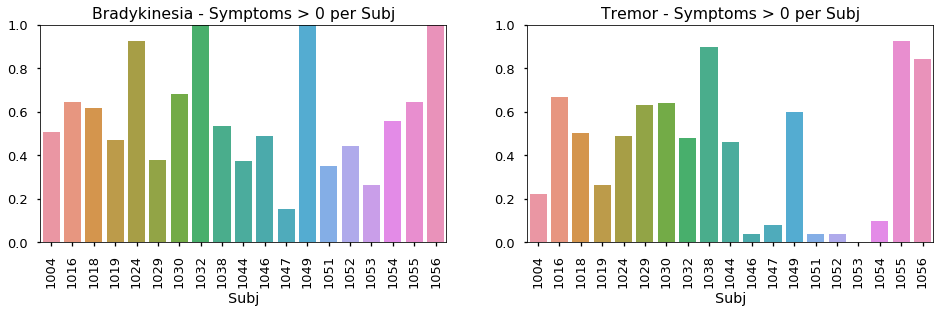

In [898]:
BradP=[]; TremorP=[]; subjs = []
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
    TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
    subjs.append(t)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
plt.ylim([0,1])
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
plt.ylim([0,1])

In [952]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

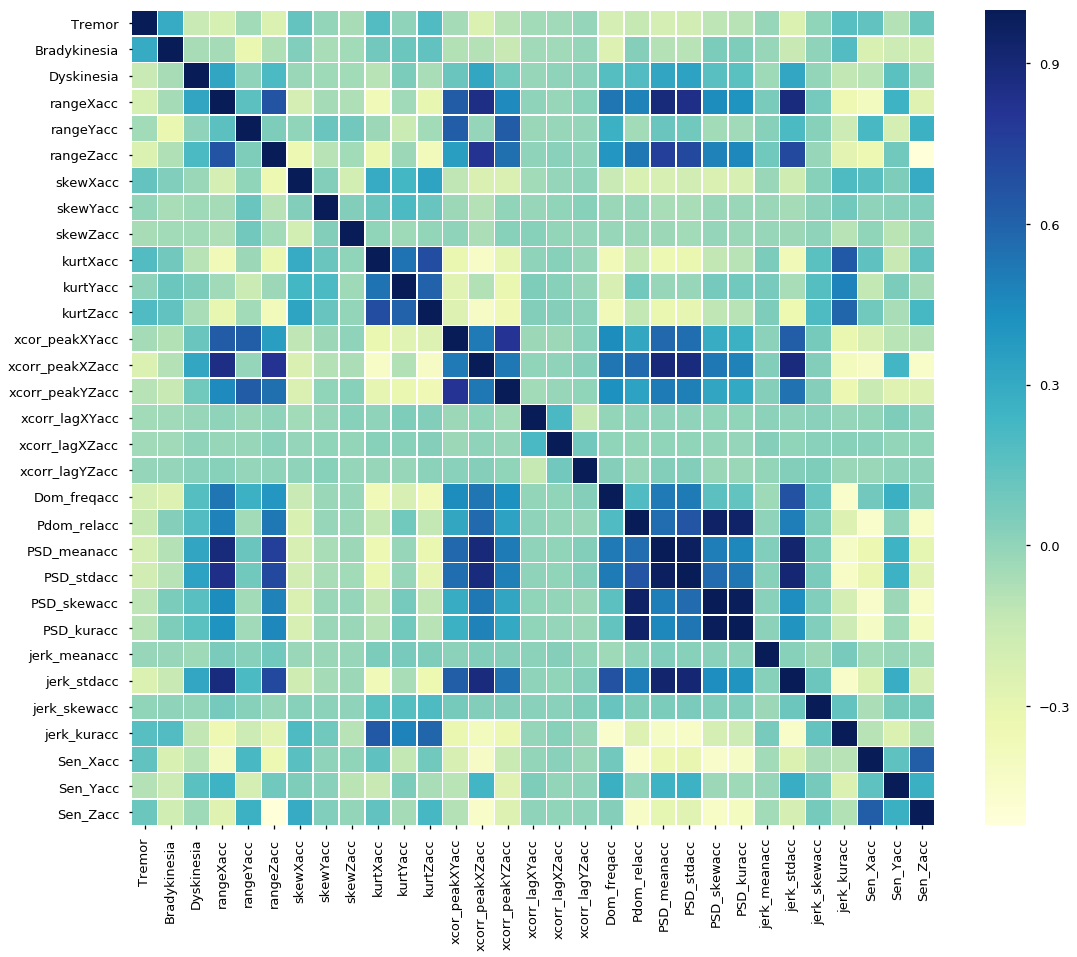

In [953]:
sns.set_context('talk')
f = Data.iloc[:,4:35]
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

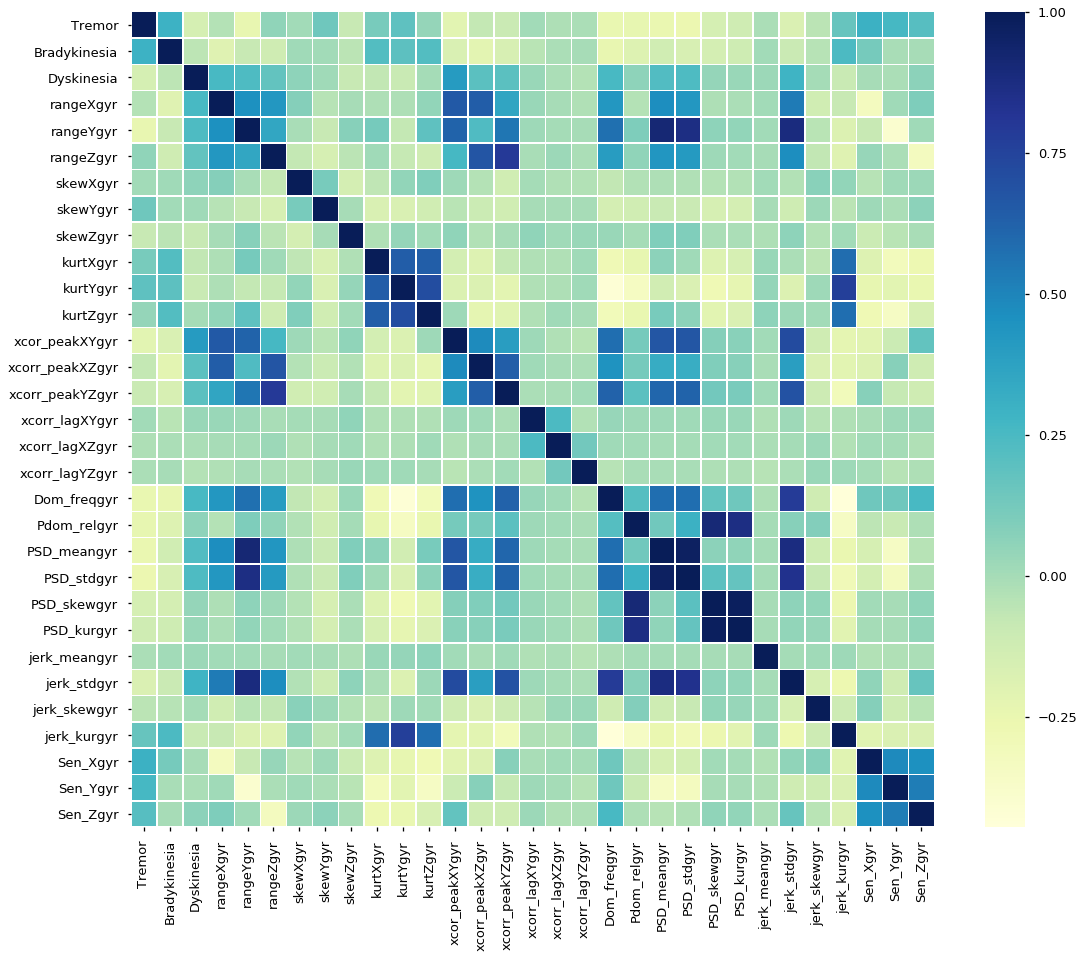

In [954]:
f = Data.iloc[:,4:7]
f = pd.concat((f,Data.iloc[:,35:]),axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

## Structured vs Functional tasks

### Use accelerometer and gyro features

Train on 1 subject - assess feature importance and number of trees

In [846]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

In [903]:
print(len(indn),len(indp))
N = min(len(indn),len(indp))
print(N)

1863 3207
1863


In [476]:
#rebalance classes 
indn = np.where(y == 0)[0]
indp = np.where(y > 0)[0]

N = max(len(indn),len(indp)) 
nratio = 1
pratio = 1
Nneg=nratio*N
Npos=pratio*N

indn_new = np.random.choice(indn,Nneg,replace=True)
indp_new = np.random.choice(indp,Npos,replace=True)

#should add noise or jitter clips to obtain new data

In [956]:
t1=time.time()
res_all = pd.DataFrame()

#use all data
X = Data.iloc[:,7:].as_matrix()

#standardize features (should be done in the CV loop)
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns

for symptom in ['Bradykinesia']:

    #use all data
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    groups = Data.Subject.as_matrix()

#     #balance classes
#     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
#     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
#     y=(y>0).values.astype(int)
#     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']
    
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2),GradientBoostingClassifier(c)]
              #SVC(cache_size=800,probability=True)]          
#           XGBClassifier()]
    model_name = ['Random Forest','GB']#,'SVM']#,'XGB']
    models = list(zip(models,model_name))
    
    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1877/3207 = 0.59
Training Random Forest

Subj/Visit 0, prec=0.580, rec=0.323, Spec=0.761, auroc_train=1.000, auroc=0.572

Subj/Visit 1, prec=0.632, rec=0.883, Spec=0.070, auroc_train=1.000, auroc=0.404

Subj/Visit 2, prec=0.698, rec=0.970, Spec=0.323, auroc_train=1.000, auroc=0.816

Subj/Visit 3, prec=0.703, rec=0.887, Spec=0.667, auroc_train=1.000, auroc=0.862

Subj/Visit 4, prec=0.967, rec=0.780, Spec=0.667, auroc_train=1.000, auroc=0.845

Subj/Visit 5, prec=0.465, rec=0.828, Spec=0.425, auroc_train=1.000, auroc=0.609

Subj/Visit 6, prec=0.784, rec=0.901, Spec=0.474, auroc_train=1.000, auroc=0.774
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.989, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.580, rec=0.860, Spec=0.284, auroc_train=1.000, auroc=0.587

Subj/Visit 9, prec=0.442, rec=1.000, Spec=0.248, auroc_train=1.000, auroc=0.694

Subj/Visit 10, prec=0.619, rec=0.833, Spec=0.512, auroc_train=1.000, auroc=0.772

Subj/Visit 11, prec=0.356, rec=0.913, Spec=0.705, auroc_train=1.000, auroc=0.881
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.989, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.650, rec=0.236, Spec=0.931, auroc_train=1.000, auroc=0.748

Subj/Visit 14, prec=0.782, rec=0.897, Spec=0.802, auroc_train=1.000, auroc=0.844

Subj/Visit 15, prec=0.214, rec=0.500, Spec=0.340, auroc_train=1.000, auroc=0.380

Subj/Visit 16, prec=0.841, rec=0.829, Spec=0.804, auroc_train=1.000, auroc=0.904

Subj/Visit 17, prec=0.902, rec=0.435, Spec=0.915, auroc_train=1.000, auroc=0.690
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.721, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.700+/-0.196, prec=0.696+/-0.222, rec=0.778+/-0.225, auprc=0.725+/-0.216
Training GB


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 0, prec=0.621, rec=0.456, Spec=0.716, auroc_train=0.980, auroc=0.626

Subj/Visit 1, prec=0.621, rec=0.874, Spec=0.035, auroc_train=0.979, auroc=0.223

Subj/Visit 2, prec=0.722, rec=0.960, Spec=0.403, auroc_train=0.975, auroc=0.822

Subj/Visit 3, prec=0.594, rec=0.787, Spec=0.522, auroc_train=0.978, auroc=0.800

Subj/Visit 4, prec=0.966, rec=0.767, Spec=0.667, auroc_train=0.973, auroc=0.776

Subj/Visit 5, prec=0.446, rec=0.844, Spec=0.368, auroc_train=0.976, auroc=0.594

Subj/Visit 6, prec=0.779, rec=0.876, Spec=0.474, auroc_train=0.978, auroc=0.773
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.984, Spec=nan, auroc_train=0.974, auroc=nan

Subj/Visit 8, prec=0.536, rec=0.796, Spec=0.210, auroc_train=0.978, auroc=0.481

Subj/Visit 9, prec=0.407, rec=0.938, Spec=0.183, auroc_train=0.971, auroc=0.606

Subj/Visit 10, prec=0.675, rec=0.718, Spec=0.671, auroc_train=0.976, auroc=0.736

Subj/Visit 11, prec=0.328, rec=0.957, Spec=0.651, auroc_tr

In [957]:
le = LabelEncoder()
# aurocall = res_group['Random Forest']['auroc']
# aurocall = res_group['GB']['auroc']
subj = le.fit_transform(np.unique(groups))

In [958]:
res_group['Random Forest'].keys()

dict_keys(['fi', 'auroc', 'f1', 'auprc', 'fpr', 'spec', 'tpr', 'rec'])

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


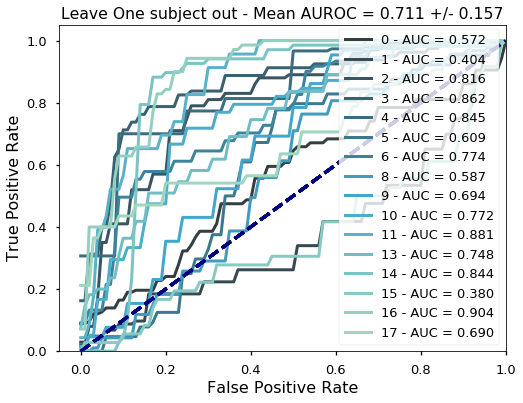

In [964]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(res_group['Random Forest']['tpr'])):
    if len(res_group['Random Forest']['tpr'][v]) == 0:
        continue
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],res_group['Random Forest']['auroc'][v],
                ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

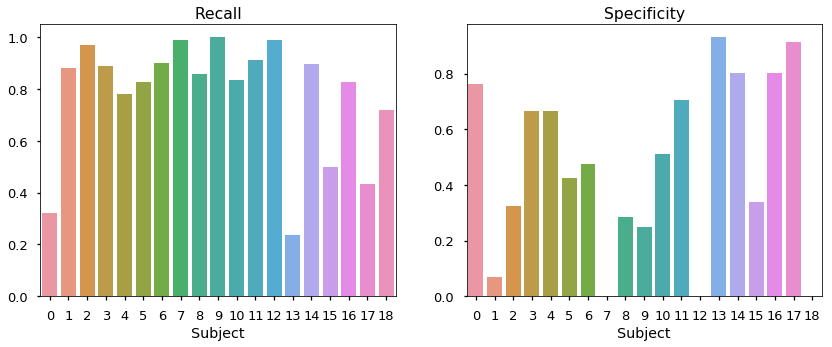

In [960]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['rec'])
plt.title('Recall')
plt.xlabel('Subject')
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['spec'])
plt.title('Specificity')
plt.xlabel('Subject')

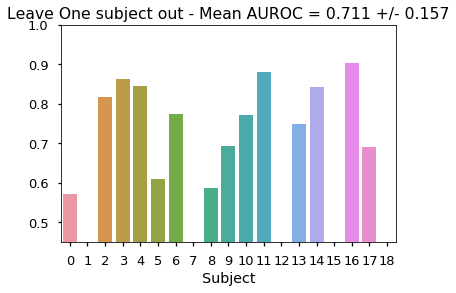

In [962]:
sns.set_context('talk')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['Random Forest']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

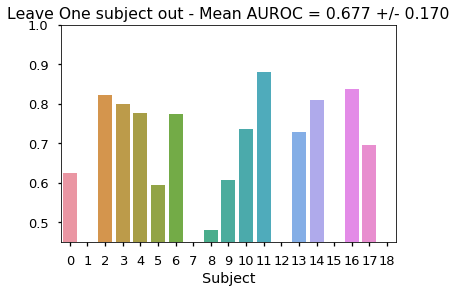

In [966]:
sns.set_context('talk')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['GB']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Feature importance

In [922]:
fi = np.asarray(res_group['Random Forest']['fi'])
meanfi=np.mean(np.asarray(res_group['Random Forest']['fi']),axis=0)
stdfi=np.std(np.asarray(res_group['Random Forest']['fi']),axis=0)

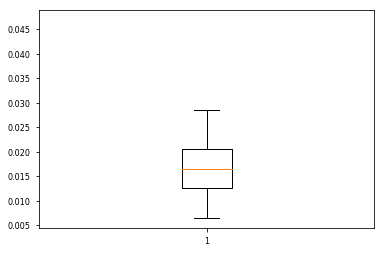

In [931]:
ax=plt.boxplot(meanfi)

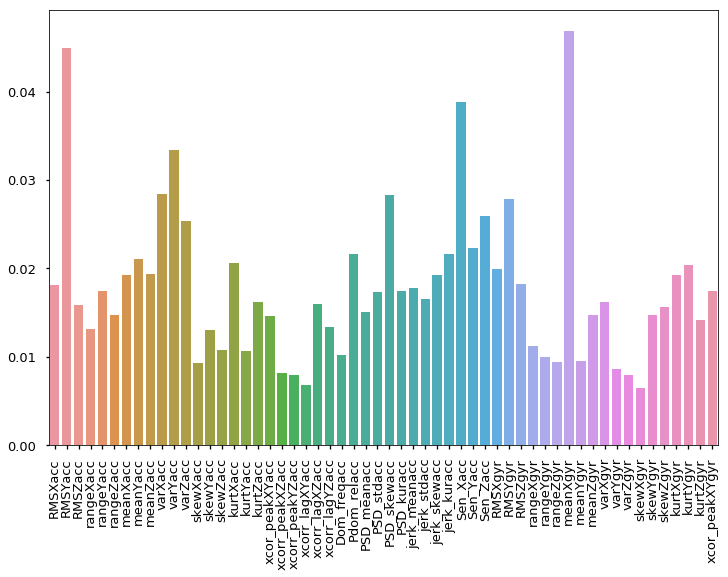

In [939]:
plt.figure(figsize=(12,8))
sns.barplot(x=np.arange(len(rf.feature_importances_)),y=meanfi,ci=stdfi)
ax=plt.xticks(np.arange(len(rf.feature_importances_)),fnames,rotation=90)

In [925]:
np.percentile(meanfi,75)

0.020469610798760085

In [926]:
sum(meanfi>0.02)

15

In [938]:
#top 14 features
fnames.values[np.argsort(meanfi)[::-1]][:14]

array(['meanXgyr', 'RMSYacc', 'Sen_Xacc', 'varYacc', 'varXacc',
       'PSD_skewacc', 'RMSYgyr', 'Sen_Zacc', 'varZacc', 'Sen_Yacc',
       'jerk_kuracc', 'Pdom_relacc', 'meanYacc', 'kurtXacc'], dtype=object)

In [937]:
fnames.values[np.argsort(meanfi)[::-1]][:n]

array(['meanXgyr', 'RMSYacc', 'Sen_Xacc', 'varYacc', 'varXacc',
       'PSD_skewacc', 'RMSYgyr', 'Sen_Zacc', 'varZacc', 'Sen_Yacc',
       'jerk_kuracc', 'Pdom_relacc', 'meanYacc', 'kurtXacc'], dtype=object)

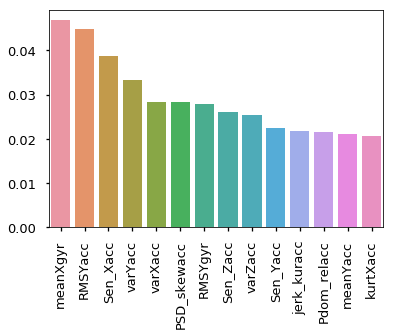

In [936]:
n = 14
sns.barplot(np.arange(n),np.sort(meanfi)[::-1][:n])
ax=plt.xticks(np.arange(n),fnames.values[np.argsort(meanfi)[::-1]][:n],rotation=90)

### Feature selection - Retrain on top 14 features

In [929]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    groups = Data.Subject.as_matrix()

#     #balance classes
#     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
#     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
#     y=(y>0).values.astype(int)
#     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

    #top features
    topf = fnames.values[np.argsort(meanfi)[::-1]][:14]
#     topf = fnames.values[:14]
    X = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1).iloc[:,7:].as_matrix()
    y = pd.concat((Data.iloc[:,:7],Data[topf]),axis=1)[symptom]
    y=(y>0).values.astype(int)
    
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
    print(X.shape)

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    
    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 1877/3207 = 0.59
(3207, 14)
Training Random Forest

Subj/Visit 0, prec=0.817, rec=0.310, Spec=0.929, auroc_train=1.000, auroc=0.667

Subj/Visit 1, prec=0.615, rec=0.854, Spec=0.035, auroc_train=1.000, auroc=0.232

Subj/Visit 2, prec=0.678, rec=0.970, Spec=0.258, auroc_train=1.000, auroc=0.717

Subj/Visit 3, prec=0.741, rec=0.787, Spec=0.756, auroc_train=1.000, auroc=0.844

Subj/Visit 4, prec=0.929, rec=0.953, Spec=0.083, auroc_train=1.000, auroc=0.786

Subj/Visit 5, prec=0.587, rec=0.844, Spec=0.642, auroc_train=1.000, auroc=0.767

Subj/Visit 6, prec=0.786, rec=0.851, Spec=0.509, auroc_train=1.000, auroc=0.800
only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=1.000, rec=0.984, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 8, prec=0.612, rec=0.763, Spec=0.444, auroc_train=1.000, auroc=0.657

Subj/Visit 9, prec=0.471, rec=1.000, Spec=0.330, auroc_train=1.000, auroc=0.684

Subj/Visit 10, prec=0.656, rec=0.756, Spec=0.622, auroc_train=1.000, auroc=0.775

Subj/Visit 11, prec=0.207, rec=1.000, Spec=0.318, auroc_train=1.000, auroc=0.881
only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=1.000, rec=0.995, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 13, prec=0.733, rec=0.400, Spec=0.921, auroc_train=1.000, auroc=0.740

Subj/Visit 14, prec=0.779, rec=0.882, Spec=0.802, auroc_train=1.000, auroc=0.882

Subj/Visit 15, prec=0.228, rec=0.500, Spec=0.390, auroc_train=1.000, auroc=0.441

Subj/Visit 16, prec=0.714, rec=0.786, Spec=0.607, auroc_train=1.000, auroc=0.798

Subj/Visit 17, prec=0.836, rec=0.541, Spec=0.809, auroc_train=1.000, auroc=0.699
only 1 class in test data - cannot compute roc curve

Subj/Visit 18, prec=1.000, rec=0.786, Spec=nan, auroc_train=1.000, auroc=nan
f1_test=0.709+/-0.190, prec=0.705+/-0.220, rec=0.788+/-0.202, auprc=0.733+/-0.198
Elapsed time = 0.324 min


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


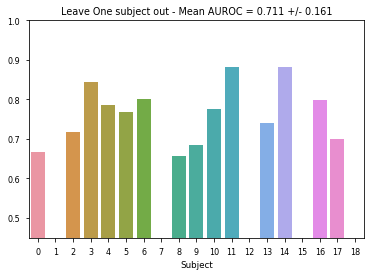

In [930]:
sns.set_context('paper')
le = LabelEncoder()
subj = le.fit_transform(np.unique(groups))
aurocall = res_group['Random Forest']['auroc']
# fig=plt.figure(figsize=(12,4))
# fig.add_subplot(121)
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [585]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


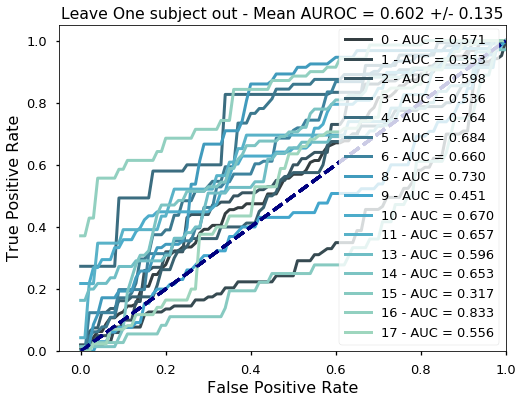

In [586]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(res_group['Random Forest']['tpr'])):
    if len(res_group['Random Forest']['tpr'][v]) == 0:
        continue
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

(0.45, 1.0)

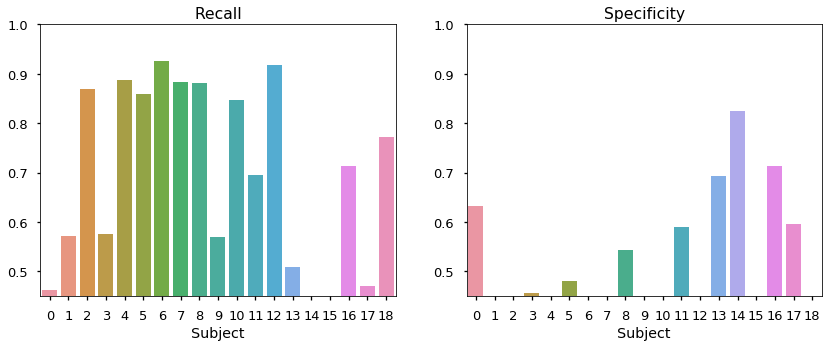

In [587]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['rec'])
plt.title('Recall')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['spec'])
plt.title('Specificity')
plt.xlabel('Subject')
plt.ylim([0.45,1.])

(0.45, 1.0)

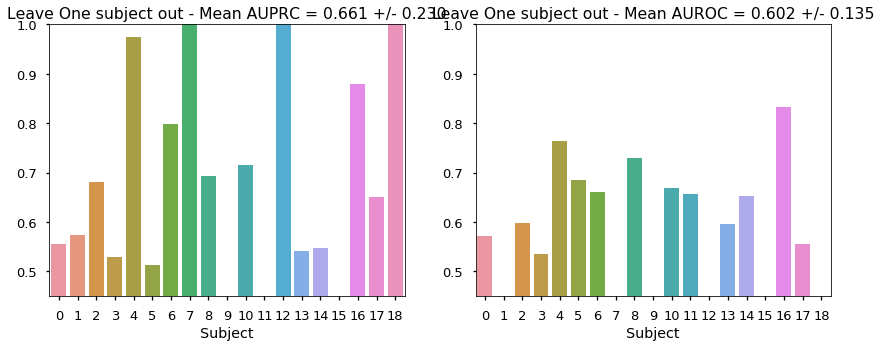

In [588]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(121)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['auprc'])
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.nanmean(auprcall),np.nanstd(auprcall)))
fig.add_subplot(122)
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=res_group['Random Forest']['auroc'])
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.ylim([0.45,1.])

## Try with k-fold CV

In [98]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Random Forest
f1_train=1.000+/-0.000, f1_test=0.556+/-0.008, prec=0.843+/-0.016, rec=0.415+/-0.010, auprc=0.736+/-0.005
[[4294  121]
 [ 743  541]]
XGB
f1_train=0.468+/-0.006, f1_test=0.447+/-0.015, prec=0.758+/-0.010, rec=0.317+/-0.014, auprc=0.637+/-0.005
[[4279  136]
 [ 843  441]]
Rows w Bradykinesia 13734/28499 = 0.48
Random Forest
f1_train=1.000+/-0.000, f1_test=0.758+/-0.005, prec=0.773+/-0.004, rec=0.743+/-0.008, auprc=0.850+/-0.003
[[2338  615]
 [ 731 2015]]
XGB
f1_train=0.721+/-0.002, f1_test=0.703+/-0.009, prec=0.693+/-0.008, rec=0.714+/-0.011, auprc=0.758+/-0.008
[[2040  913]
 [ 823 1923]]


In [109]:
t1=time.time()
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('\nRows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=True)

print('Elapsed time = %.3f'%(round(time.time()-t1)))


Rows w Tremor 6421/28499 = 0.23
Npos = 5137, Nneg = 5137
Random Forest
f1_train=1.000+/-0.000, f1_test=0.613+/-0.007, prec=0.505+/-0.010, rec=0.781+/-0.010, auprc=0.698+/-0.009
[[3401 1014]
 [ 291  993]]
Npos = 5137, Nneg = 5137
XGB
f1_train=0.784+/-0.004, f1_test=0.570+/-0.010, prec=0.458+/-0.010, rec=0.755+/-0.017, auprc=0.627+/-0.006
[[3259 1156]
 [ 302  982]]

Rows w Bradykinesia 13734/28499 = 0.48
Npos = 10988, Nneg = 10988
Random Forest
f1_train=1.000+/-0.000, f1_test=0.763+/-0.009, prec=0.758+/-0.009, rec=0.767+/-0.010, auprc=0.848+/-0.005
[[2245  708]
 [ 672 2074]]
Npos = 10988, Nneg = 10988
XGB
f1_train=0.735+/-0.001, f1_test=0.707+/-0.009, prec=0.678+/-0.008, rec=0.739+/-0.012, auprc=0.757+/-0.009
[[1941 1012]
 [ 767 1979]]
Elapsed time = 131.000
